In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import re

In [3]:
SAT_filename = r'C:\Users\Gouth_000\2012_SAT_Results.csv'
df = pd.read_csv(SAT_filename)

Let's do some Initial checks to see the some of the data and what we are dealing with

In [4]:
df.head(20)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384
5,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,112,332,557,316
6,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522,574,525
7,01M650,CASCADES HIGH SCHOOL,18,417,418,411
8,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624,604,628
9,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395,400,387


In [5]:
# Let's get some of types of data present
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             478 non-null object
SAT Critical Reading Avg. Score    478 non-null object
SAT Math Avg. Score                478 non-null object
SAT Writing Avg. Score             478 non-null object
dtypes: object(6)
memory usage: 22.5+ KB
None
(478, 6)


 Let's study the Reading scores of two districts in New York - Districts 1 and 2. 
 Specifically, I'm going to analyze the probability that the reading scores of district 1 and 2 are pulling data from the same distribution. The null hypothesis will be that the means of average reading scores between district 1 and 2 will be equal to one another. 

In [6]:
# First, I'll extract district 1 and district 2 data
pattern1 = '^01'
pattern2 = '^02'
district1 = df[df.DBN.str.contains(pattern1)].reset_index(drop=True)
district2 = df[df.DBN.str.contains(pattern2)].reset_index(drop=True)

#Re-labelling the columns for easier calling later on
district1.columns = ['DBN','School','Number','Reading','Math','Writing']
district2.columns = ['DBN','School','Number','Reading','Math','Writing']

# Let's remove some of the missing data
district2 = district2[district2.Number != 's']

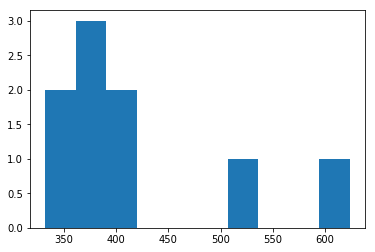

In [7]:
# Let's study the distributions of district 1 and district 2 reading scores 
plt.hist(district1['Reading'].astype(int))
plt.show()

Looks to be a skewed distribution. Assuming that the test scores of individual students in each school are normally distributed, we'll assume the average reading scores of all schools in District 1 are also normally distributed and that applying CLT, it'll converge to a normal distribution with an increased school sample size. 

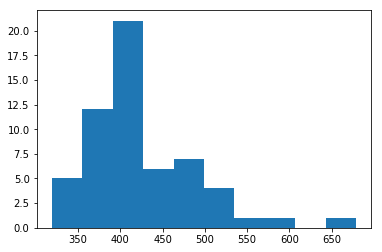

In [16]:
plt.hist(district2['Reading'].astype(int))
plt.show()

Looks to resemble more of a normal distribution

In [11]:
# 2 - sample t-test 
pval = ttest_ind(district1['Reading'].astype(int),district2['Reading'].astype(int)).pvalue
print(pval)

0.9905790070795285


Under the null hypothesis, there is at least a 99% chance of attaining the observed difference in reading score means between district 1 and district 2 suggesting that the average reading scores between district 1 and 2 are not very different, so we accept the null hypothesis that the average reading scores of districts 1 and 2 come from the same distribution of average reading scores. 

Because the district 1 data isn't exactly normally distributed from the sample size given, the 2 sample t-test may not hold accurate results. Let's try permutation replicate sampling of the two district's reading score data and see what the probability is of observing the mean difference in average reading scores between the two districts.

# Permutation Sampling and Replicates Technique

Here, I'm going to combine the two districts reading data into 1 list and perform 10,000 permutation sampling replicates of the difference in reading score means, assuming both district's data are pulling from the same distribution. Then I'll see how many permutation replicates are at least or greater than the observed difference in reading score means from the two districts within the current data-set. 

In [12]:
# Here I'm going to concatenate district 1 reading and district 2 reading into one list and permute the data
# I'm essentially making the assumption that these two datas are from the same distribution.
def permutation_sample(data1,data2):
    data = np.concatenate((data1,data2))
    permutated_data = np.random.permutation(data)
    perm_sample_1 = permutated_data[:len(data1)]
    perm_sample_2 = permutated_data[len(data1):]
    
    return perm_sample_1, perm_sample_2

# Here I'm going to perform permutation sampling 10,000 times and calculating the difference in means of average reading scores between district 1 and district 2.

def draw_perm_reps(data_1, data_2, func, size=1):
    
    perm_replicates = np.empty(size)

    for i in range(size):
    
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

# This is the function used to calculate the difference in means

def diff_of_means(data_1, data_2):

    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [14]:
# Applying to our data-sets
d1 = district1['Reading'].astype(int)
d2 = district2['Reading'].astype(int)
diff_means = diff_of_means(d1,d2)
perm_replicates = draw_perm_reps(d1, d2,diff_of_means, size=10000)
p = np.sum(perm_replicates >= diff_means) / len(perm_replicates)
print(p)

0.474


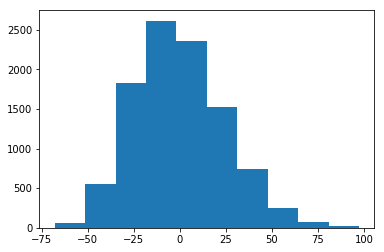

In [15]:
plt.hist(perm_replicates)
plt.show()

This resembles more of a normal distribution 

There is a 47% chance that the difference in reading score means is observed from the current data-set assuming that the distribution of the difference in average reading scores of both districts are the same. We can conclude that the average reading scores between the two districts are pulling from a similar distribution. 

# End